<a href="https://colab.research.google.com/github/meirelon/hockey_data/blob/main/hockey_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import requests
from datetime import date, timedelta
import pickle    
import matplotlib
import matplotlib.pyplot as plt
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math 

plt.style.use('fivethirtyeight')
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors

c = mcolors.ColorConverter().to_rgb
positive_cm = ListedColormap([c('#e1e5e5'),c('#e78c79'),c('#d63b36')])
negative_cm = ListedColormap([c('#e1e5e5'), c('#a1ceee'),c('#28aee4')])

from PIL import Image
pd.options.mode.chained_assignment = None

import ipywidgets as widgets
from ipywidgets import interact

In [13]:
# @interact(player="")
# def g(player):
#      player_heatmap(player)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/hockey_db/data"

Mounted at /content/drive


In [4]:
metadata_path = f"{file_path}/metadata/metadata.csv"
metadata = pd.read_csv(metadata_path)

In [5]:
live_games_path = f"{file_path}/stats/liveGames/live_games.csv"
live_games = pd.read_csv(live_games_path)

In [6]:
live_games_unnested_path = f"{file_path}/stats/liveGames/live_games_unnested.csv"
live_games_unnested = pd.read_csv(live_games_unnested_path)
live_games_unnested.columns = ["id", "fullName", "link", "event_uuid", "gamepk", "event_type"]

In [7]:
merge_columns = ["id", "fullName", "link", "event_uuid", "gamepk", "event_type", "result_event", "coordinates_x", "coordinates_y"]

In [8]:
live_games_merged = live_games_unnested.merge(live_games, on=["event_uuid", "gamepk"], how="inner")[merge_columns]

In [9]:
def normalize_coordinates(df):
    df["x_normalized"] = abs(df["coordinates_x"])
    df["y_normalized"] = -df["coordinates_y"]
    return df

def proportion(df, numerator_event, numerator_result, denominator_event, denominator_result):
    events = df.groupby(["event_type", "result_event"]).agg({"event_uuid": ["nunique"]})
    numerator = events.query(f"event_type == '{numerator_event}' & result_event == '{numerator_result}'").values[0]
    denominator = events.query(f"event_type == '{denominator_event}' & result_event == '{denominator_result}'").values[0]
    return numerator/denominator

def get_hex_data(df, player):
    metadata_path = f"{file_path}/metadata/metadata.csv"
    metadata = pd.read_csv(metadata_path)
    hex_dict = {}
    position = metadata[metadata["fullName"] == player]["primaryPosition_code"].values[0]
    print(position)
    df = normalize_coordinates(df)
    if position == "G":
            shots_mask = "event_type == 'Goalie' & result_event in ('Goal', 'Shot')"
            goals_mask = "event_type == 'Goalie' & result_event == 'Goal'"
    else:
        shots_mask = "event_type in ('Scorer','Shooter') & result_event in ('Goal', 'Shot')"
        goals_mask = "event_type == 'Scorer' & result_event == 'Goal'"
    for run in ["league", "player"]:
        if run == "player":
            df = df[df["fullName"] == player]
        xbnds = np.array([-100.,100.0])
        ybnds = np.array([-100,100])
        extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]
        gridsize= 30
        mincnt=0
        shots_x = df.query(shots_mask)["x_normalized"]
        shots_y = df.query(shots_mask)["y_normalized"]
        goals_x = df.query(goals_mask)["x_normalized"]
        goals_y = df.query(goals_mask)["y_normalized"]
        hex_data = plt.hexbin(shots_x,shots_y,gridsize=gridsize,extent=extent,mincnt=mincnt,alpha=0.0)
        verts = hex_data.get_offsets();
        frequency = hex_data.get_array();
        goal_hex_data = plt.hexbin(goals_x,goals_y,gridsize=gridsize,extent=extent,mincnt=mincnt,alpha=0.0)
        goal_frequency = goal_hex_data.get_array()
        hex_dict[run] = {"frequency": frequency, "goal_frequency": goal_frequency, "verts": verts}
    return hex_dict

def get_efficiency(league_frequency, league_goal_frequency, player_frequency, player_goal_frequency):
    league_efficiency = []
    player_efficiency = []
    relative_efficiency = []
    for i in range(0,len(league_frequency)):
        if league_frequency[i]<2 or player_frequency[i]<2:
            continue
        league_efficiency.append(league_goal_frequency[i]/league_frequency[i])
        player_efficiency.append(player_goal_frequency[i]/player_frequency[i])
        relative_efficiency.append((player_goal_frequency[i]/player_frequency[i])-(league_goal_frequency[i]/league_frequency[i]))
    return {"max_league_efficiency": max(league_efficiency), "max_player_efficiency": max(player_efficiency), "max_relative_efficiency": max(relative_efficiency), "min_relative_efficiency": min(relative_efficiency)}

In [10]:
def player_heatmap(player: str):
    hex_data = get_hex_data(live_games_merged, player = player)
    fig=plt.figure(figsize=(50,50))
    ax = fig.add_subplot(111)
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")
    fig.patch.set_alpha(0.0)
    ax.set_xticklabels(labels = [''], fontsize = 18,alpha = .7,minor=False)
    ax.set_yticklabels(labels = [''], fontsize = 18,alpha = .7,minor=False)
    I = Image.open(f'{file_path}/half.png')
    ax.imshow(I)
    width, height = I.size
    scalingx=width/100-0.6
    scalingy=height/100+0.5
    x_trans=33
    y_trans=height/2
    S = 3.8*scalingx;gridsize= 30
    mincnt=0
        
    best_spot = []
    best_spot_r = 0.0
    tmp_eff = -1

    player_verts = hex_data["player"]["verts"]
    player_frequency = hex_data["player"]["frequency"]
    player_goal_frequency = hex_data["player"]["goal_frequency"]
    league_frequency = hex_data["league"]["frequency"]
    league_goal_frequency = hex_data["league"]["goal_frequency"]

    for i,v in enumerate(player_verts):
        if player_frequency[i] < 4:
            continue
        player_scaled_frequency = player_frequency[i]/max(player_frequency) # Gives the percentage of shots made at that location compared to the max location
        radius = S*math.sqrt(player_scaled_frequency)

        player_efficiency = player_goal_frequency[i]/player_frequency[i]
        league_efficiency = league_goal_frequency[i]/league_frequency[i]
        relative_efficiency = player_efficiency - league_efficiency
        relative_efficiency = relative_efficiency
        if tmp_eff < relative_efficiency:
            tmp_eff=relative_efficiency;
            best_spot = [x_trans+v[0]*scalingx,y_trans+ v[1]*scalingy]
            best_spot_r = radius
        if relative_efficiency>0:
            colour = positive_cm(math.pow(relative_efficiency,0.1))
        else:
            colour = negative_cm(math.pow(-relative_efficiency,0.1))

        hex = RegularPolygon((x_trans+v[0]*scalingx, y_trans+ v[1]*scalingy), \
                            numVertices=6, radius=radius, orientation=np.radians(0), \
                            facecolor=colour, alpha=1.0, edgecolor=None)
        ax.add_patch(hex) 
        
    hex = RegularPolygon(best_spot, numVertices=6, radius=best_spot_r, orientation=np.radians(0),facecolor='#eee657', alpha=0.8, edgecolor=None)
    ax.add_patch(hex) 
    hex = RegularPolygon(best_spot, numVertices=6, radius=best_spot_r-5, orientation=np.radians(0),facecolor='#ffffff', alpha=1, edgecolor=None)
    ax.add_patch(hex) 

    hex = RegularPolygon(best_spot, numVertices=6, radius=best_spot_r-10, orientation=np.radians(0),facecolor='#eee657', alpha=1, edgecolor=None)
    ax.add_patch(hex) 
        
    ax.set_xlim([0,width])
    ax.set_ylim([0,height])
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    plt.grid(False)
    plt.show();

C


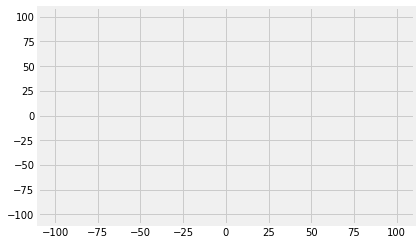

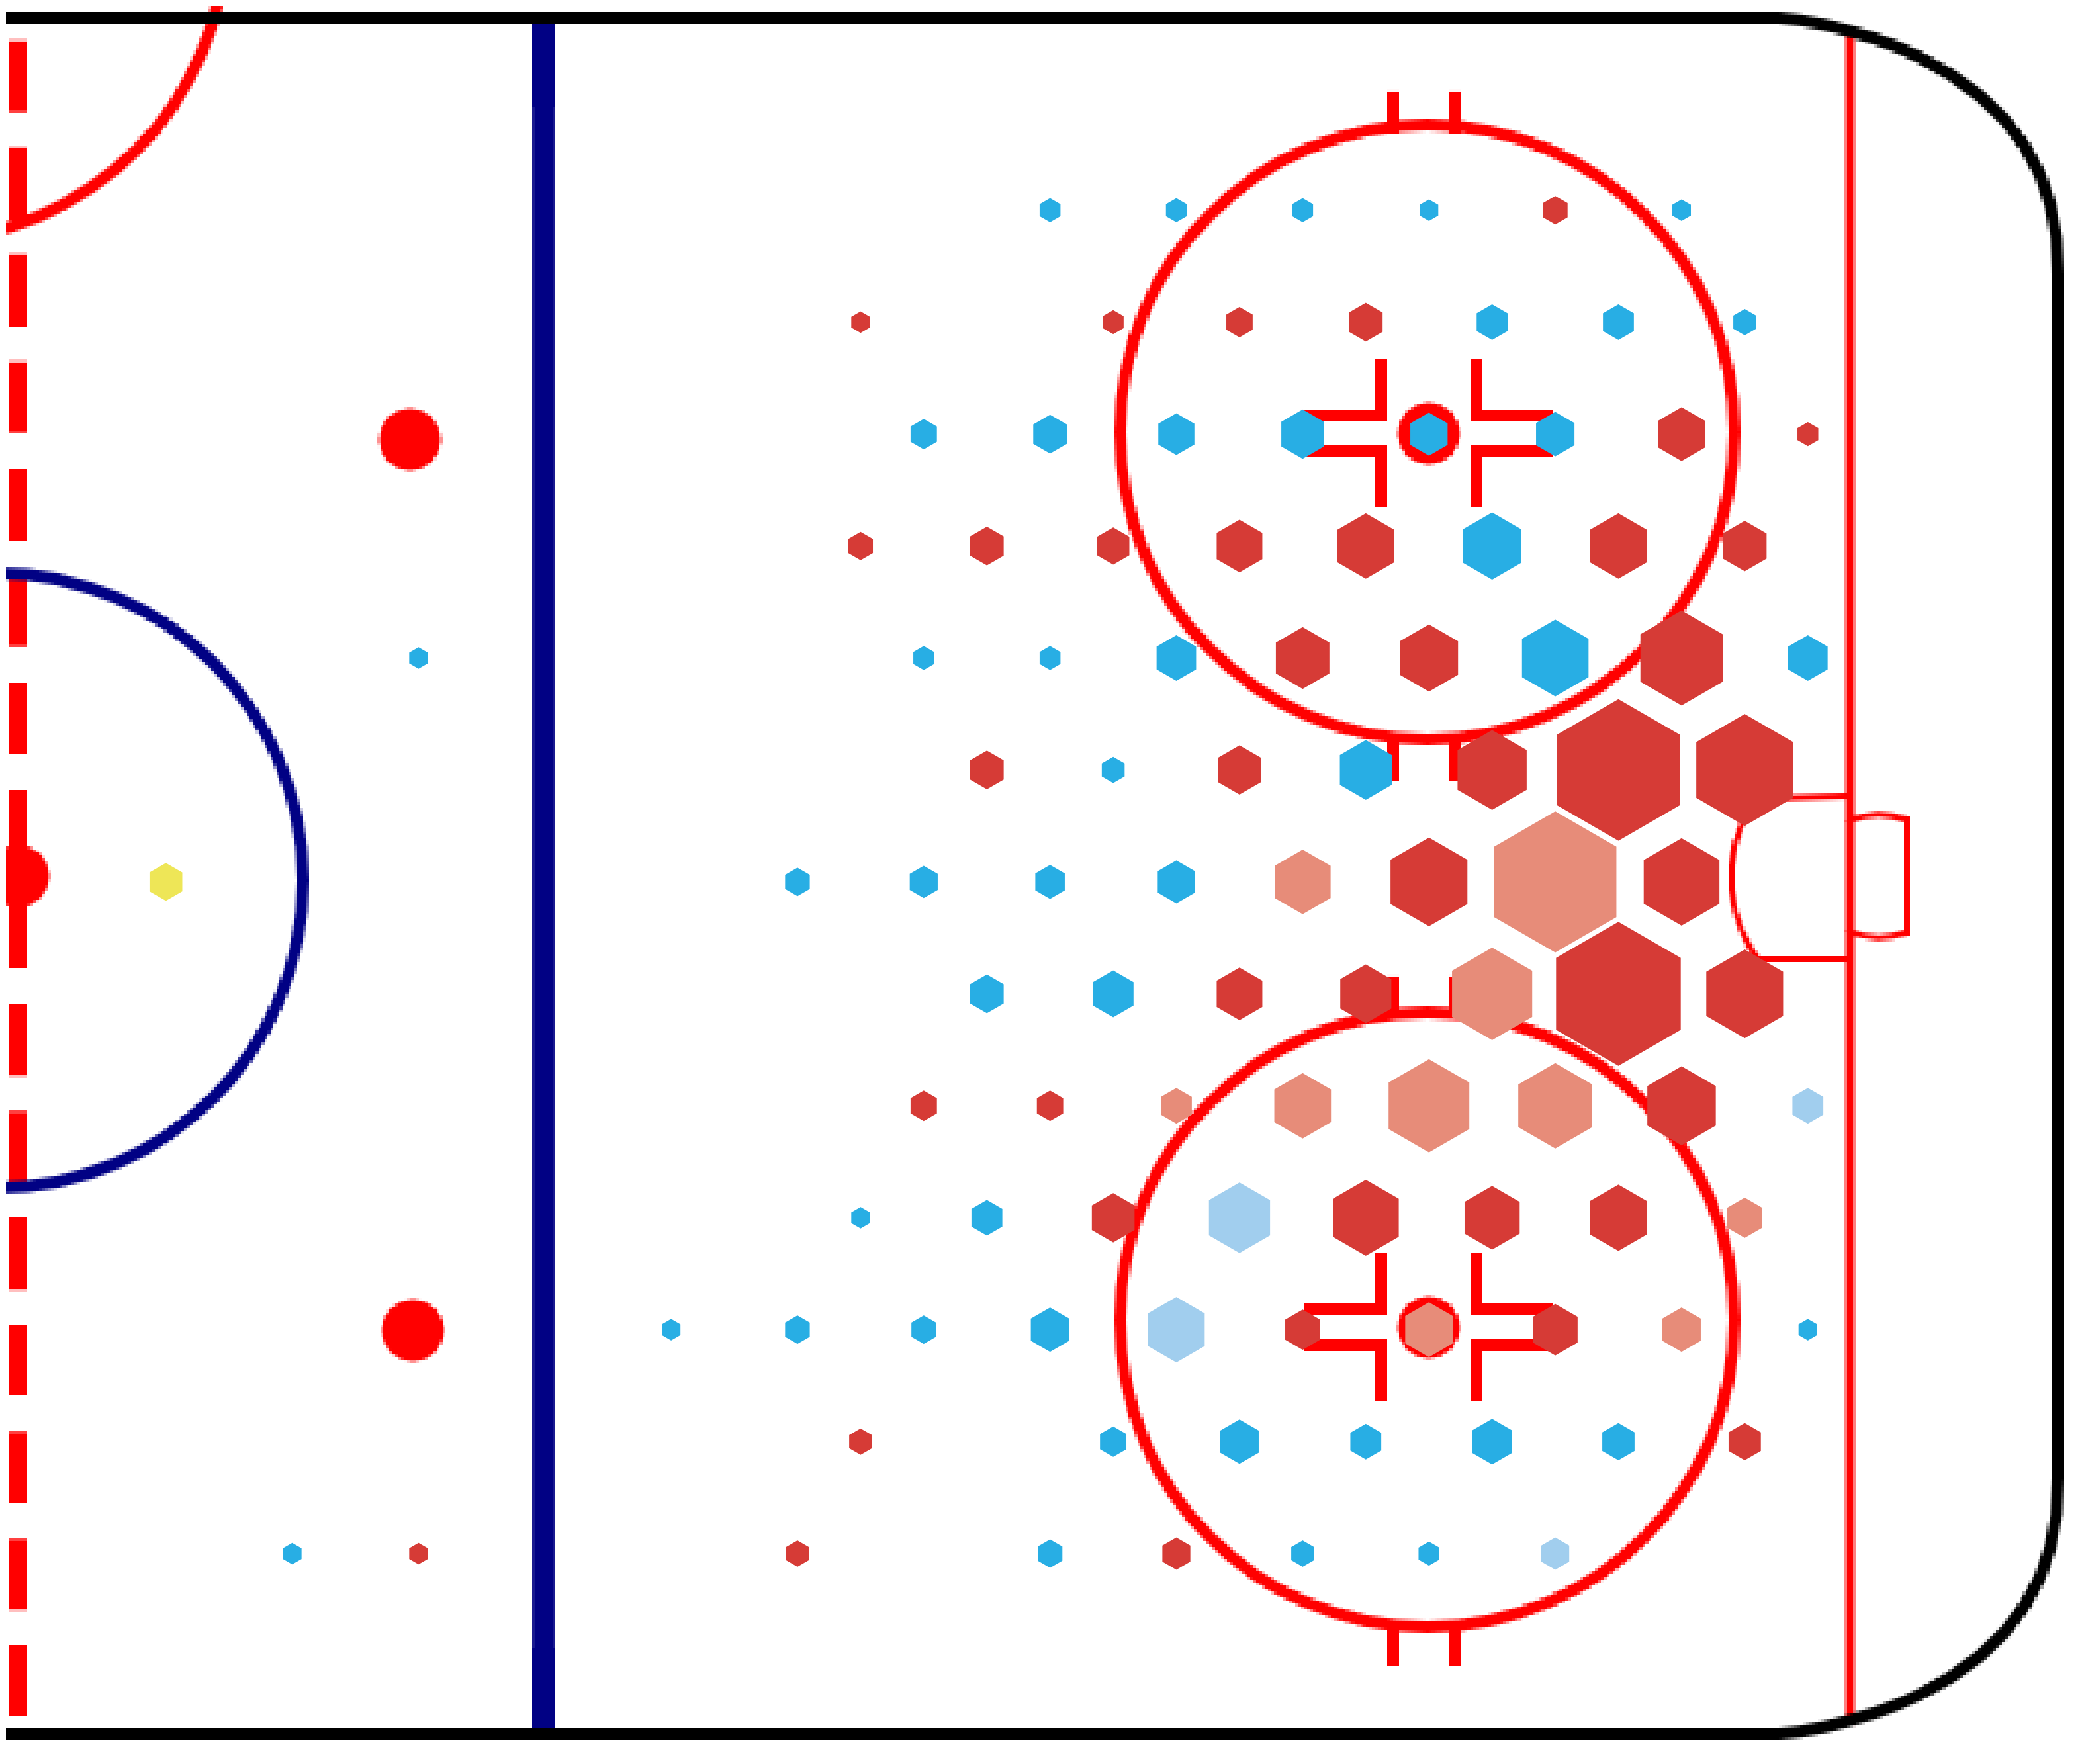

In [11]:
player_heatmap(player="Sidney Crosby")